In [1]:
import numpy as np
from astropy import coordinates as coo
from astropy import units as u
import healpy as hp
import matplotlib.pyplot as plt
import multiprocessing as mp

In [2]:
Nside_jack = 4

In [3]:
def weight_nan_mean(value, weight):
    mean_val = np.zeros(value.shape[1])
    for i in range(len(mean_val)):
        idx = np.logical_not(np.isnan(value[:,i]))
        val = value[:,i][idx]
        wei = weight[:,i][idx]
        mean_val[i] = (val*wei).sum()/wei.sum()
    return mean_val

# quasar vs random

In [4]:
# dat = np.load('../calculation_data/result_r=30_300_10_low.npy')
# dat_r = np.load('../calculation_data/result_r=30_300_10_random_low_2.npy')
dat = np.load('../calculation_data/result_r=3_100_10_quasar_low.npy')
dat_r = np.load('../calculation_data/result_r=3_100_10_random_low.npy')
value = dat[0]
value_r = dat_r[0]
weight = dat[1]
weight_r = dat_r[1]

FileNotFoundError: [Errno 2] No such file or directory: '../calculation_data/result_r=3_100_10_quasar_tree.npy'

In [6]:
from astropy.io import fits
quasar_cata = fits.getdata('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/SDSS16Q/DR16Q_v4.fits')
quasar_cata = quasar_cata[quasar_cata['Z'] > 1]
quasar_cata = quasar_cata[quasar_cata['Z'] < 3]
c = coo.SkyCoord(ra=quasar_cata['RA']*u.degree, dec=quasar_cata['DEC']*u.degree)

l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value

pix = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

In [6]:
# rand_point = np.loadtxt('../random_sample_theta_phi_z')
rand_point = np.loadtxt('../random_sample_theta_phi_5_000_000')
pix_r = hp.ang2pix(Nside_jack, rand_point[:,0], rand_point[:,1])

## random sample

In [7]:
mean_r = weight_nan_mean(value_r, weight_r)

In [8]:
def jackknife_resample_r(i):
    idx = pix_r != i
    return weight_nan_mean(value_r[idx], weight_r[idx])

In [9]:
pro = mp.Pool(20)
result = pro.map(jackknife_resample_r, np.unique(pix_r))
jack_val = np.vstack(result)

In [10]:
cov_mat = np.cov(jack_val, ddof=1, rowvar=False)
std_r = np.std(jack_val, axis=0, ddof=1)
cov_ii = [cov_mat[i,i] for i in range(cov_mat.shape[0])]
for i in range(cov_mat.shape[0]):
    for j in range(cov_mat.shape[0]):
        cov_mat[i,j] /= np.sqrt(cov_ii[i]*cov_ii[j])

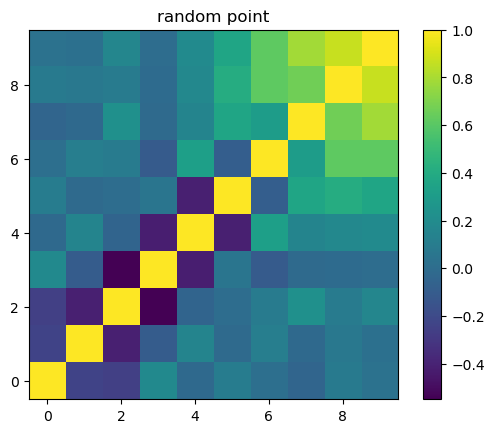

In [11]:
plt.imshow(cov_mat, origin='lower')
plt.title('random point')
plt.colorbar()

## quasar sample

In [7]:
mean = weight_nan_mean(value, weight)

In [8]:
def jackknife_resample_q(i):
    idx = pix != i
    return weight_nan_mean(value[idx], weight[idx])
pro = mp.Pool(20)
jack_val_q = np.vstack(pro.map(jackknife_resample_q, np.unique(pix)))

In [9]:
cov_mat = np.cov(jack_val_q, ddof=1, rowvar=False)
std = np.std(jack_val_q, axis=0, ddof=1)
cov_ii = [cov_mat[i,i] for i in range(cov_mat.shape[0])]
for i in range(cov_mat.shape[0]):
    for j in range(cov_mat.shape[0]):
        cov_mat[i,j] /= np.sqrt(cov_ii[i]*cov_ii[j])

Text(0.5, 1.0, 'quasar[z=1-3]')

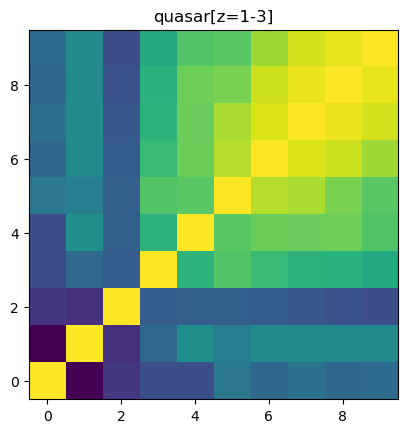

In [10]:
plt.imshow(cov_mat, origin='lower')
plt.title('quasar[z=1-3]')

[]

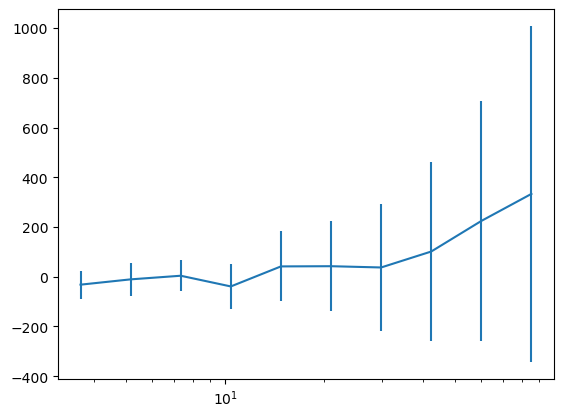

In [12]:
r_bins = np.geomspace(3, 100, 10+1)        # unit: cMpc/h
r = (r_bins[1:]+r_bins[:-1])/2

plt.errorbar(r, r*mean, r*std*len(np.unique(pix))**0.5)
plt.semilogx()

## quasar - random

In [16]:
def jackknife_resample(i):
    idx = pix != i
    idx_r = pix_r != i
    return weight_nan_mean(value[idx], weight[idx])-weight_nan_mean(value_r[idx_r], weight_r[idx_r])

In [17]:
pro = mp.Pool(20)
result = pro.map(jackknife_resample, np.unique(pix))
jack_val = np.vstack(result)

In [18]:
cov_mat = np.cov(jack_val, ddof=1, rowvar=False)
cov_ii = [cov_mat[i,i] for i in range(cov_mat.shape[0])]
for i in range(cov_mat.shape[0]):
    for j in range(cov_mat.shape[0]):
        cov_mat[i,j] /= np.sqrt(cov_ii[i]*cov_ii[j])

Text(0.5, 1.0, 'quasar[z=1-3]-random')

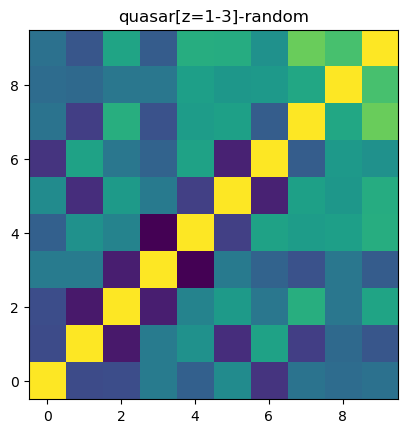

In [19]:
plt.imshow(cov_mat, origin='lower')
plt.title('quasar[z=1-3]-random')

## signal

In [20]:
r_bins = np.geomspace(3, 100, 10+1)        # unit: cMpc/h
r = (r_bins[1:]+r_bins[:-1])/2

In [21]:
sig = mean-mean_r
err = np.array(cov_ii)**0.5*np.sqrt(len(np.unique(pix)))

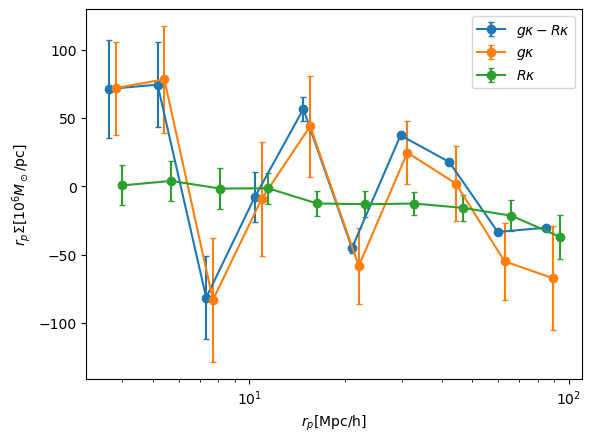

In [23]:
plt.errorbar(r, r*sig, r*err, capsize=2, fmt='-o', label='$g\\kappa-R\\kappa$')
plt.errorbar(r*1.05, r*mean, r*std*np.sqrt(len(np.unique(pix))), label='$g\\kappa$', capsize=2, fmt='-o')
plt.errorbar(r*1.05*1.05, r*mean_r, r*std_r*np.sqrt(len(np.unique(pix_r))), label='$R\\kappa$', capsize=2, fmt='-o')
plt.semilogx()
plt.xlabel('$r_p[\\mathrm{Mpc/h}]$')
plt.ylabel('$r_p\\Sigma[10^6 M_\\odot/\\mathrm{pc}]$')
# plt.xlim(right=100)
plt.legend()
plt.show()

The whole process from calculation data to signal.

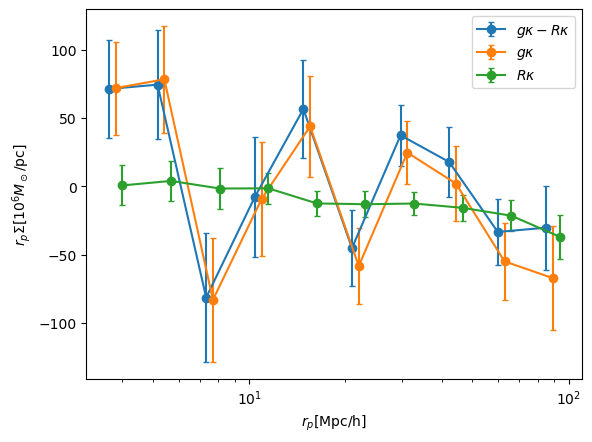

In [60]:
dat = np.load('../calculation_data/result_r=3_100_10_quasar_low.npy')
dat_r = np.load('../calculation_data/result_r=3_100_10_random_low.npy')
value = dat[0]
value_r = dat_r[0]
weight = dat[1]
weight_r = dat_r[1]
def weight_nan_mean(value, weight):
    mean_val = np.zeros(value.shape[1])
    for i in range(len(mean_val)):
        idx = np.logical_not(np.isnan(value[:,i]))
        val = value[:,i][idx]
        wei = weight[:,i][idx]
        mean_val[i] = (val*wei).sum()/wei.sum()
    return mean_val

from astropy.io import fits
quasar_cata = fits.getdata('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/SDSS16Q/DR16Q_v4.fits')
quasar_cata = quasar_cata[quasar_cata['Z'] > 1]
quasar_cata = quasar_cata[quasar_cata['Z'] < 3]
c = coo.SkyCoord(ra=quasar_cata['RA']*u.degree, dec=quasar_cata['DEC']*u.degree)
l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pix = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)
# rand_point = np.loadtxt('../random_sample_theta_phi_z')

rand_point = np.loadtxt('../random_sample_theta_phi_5_000_000')
pix_r = hp.ang2pix(Nside_jack, rand_point[:,0], rand_point[:,1])

mean = weight_nan_mean(value, weight)
def jackknife_resample_q(i):
    idx = pix != i
    return weight_nan_mean(value[idx], weight[idx])
pro = mp.Pool(20)
jack_val_q = np.vstack(pro.map(jackknife_resample_q, np.unique(pix)))
std = np.std(jack_val_q, axis=0, ddof=1)*len(np.unique(pix))**0.5


mean_r = weight_nan_mean(value_r, weight_r)
def jackknife_resample_r(i):
    idx = pix_r != i
    return weight_nan_mean(value_r[idx], weight_r[idx])
pro = mp.Pool(20)
result = pro.map(jackknife_resample_r, np.unique(pix_r))
jack_val_r = np.vstack(result)
std_r = np.std(jack_val_r, axis=0, ddof=1)*len(np.unique(pix_r))**0.5

mean_sub = mean-mean_r
def jackknife_resample(i):
    idx = pix != i
    idx_r = pix_r != i
    return weight_nan_mean(value[idx], weight[idx])-weight_nan_mean(value_r[idx_r], weight_r[idx_r])
pro = mp.Pool(20)
result = pro.map(jackknife_resample, np.unique(pix))
jack_val = np.vstack(result)
std_sub = np.std(jack_val, axis=0, ddof=1)*len(np.unique(pix))**0.5

r_bins = np.geomspace(3, 100, 10+1)        # unit: cMpc/h
r = (r_bins[1:]+r_bins[:-1])/2
sig = mean-mean_r
plt.errorbar(r, r*sig, r*std_sub, capsize=2, fmt='-o', label='$g\\kappa-R\\kappa$')
plt.errorbar(r*1.05, r*mean, r*std, label='$g\\kappa$', capsize=2, fmt='-o')
plt.errorbar(r*1.05*1.05, r*mean_r, r*std_r, label='$R\\kappa$', capsize=2, fmt='-o')
plt.semilogx()
plt.xlabel('$r_p[\\mathrm{Mpc/h}]$')
plt.ylabel('$r_p\\Sigma[10^6 M_\\odot/\\mathrm{pc}]$')
# plt.xlim(right=100)
plt.legend()
plt.show()

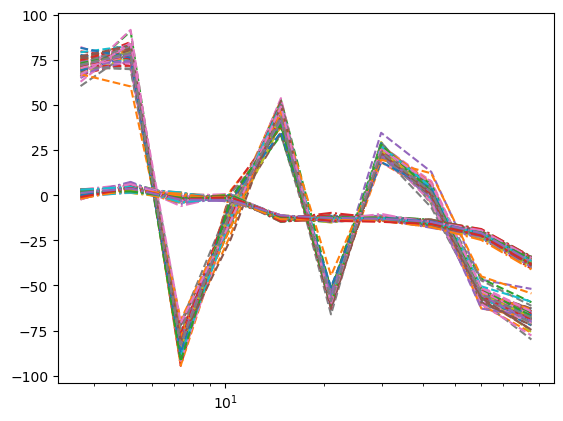

In [61]:
for i in range(jack_val_q.shape[0]):
    plt.plot(r, r*jack_val_q[i], '--')
for i in range(jack_val_r.shape[0]):
    plt.plot(r, r*jack_val_r[i], '-.')

plt.semilogx()
plt.show()